In [ ]:
# in your notebook or another script
from Data_Cleaning import get_core_filtered
from Data_Enrichment import get_features

RAW_DIR = "data/raw"

# a) only filtered core DataFrames (Big-5) in memory
core = get_core_filtered(RAW_DIR)
df_teams_season       = core["df_teams_season"]
df_teams_details      = core["df_teams_details"]
df_players_profile    = core["df_players_profile"]
df_player_performance = core["df_player_performance"]

# b) features + Ballon d'Or flag in one line
df_feats, feature_cols = get_features(RAW_DIR)
# Filter out rows where season_end_year != 2025
df_feats = df_feats[(df_feats['season_end_year'] != 2025) & (df_feats['season_end_year'] != 2026)]
# Drop the column 'ballon_dor_winner'
df_feats = df_feats.drop(columns=['ballon_dor_winner'])

/workspaces/Machine-learning/Data_Enrichment.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import textwrap
from statsmodels.tsa.stattools import adfuller


correlation analysis 

stationary test over performance variables 

In [ ]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",   
]
adf_results = []

for col in safe_cols:
    if col in df_feats.columns:
        # eliminar NA
        series = df_feats[col].dropna()
        if len(series) > 1:  # ADF necesita al menos 2 valores
            result = adfuller(series)
            adf_results.append({
                "variable": col,
                "adf_statistic": result[0],
                "p_value": result[1],
                "stationary": result[1] < 0.05
            })

adf_df = pd.DataFrame(adf_results)
print(adf_df)


In [ ]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",
    
]

X = df_feats[safe_cols].replace([np.inf, -np.inf], np.nan).dropna()
corr = X.corr(method="pearson")

# wrap labels to multiple lines (split underscores + wrap to width)
def wrap_label(s, width=12):
    s = s.replace("_", " ")
    return "\n".join(textwrap.wrap(s, width=width))

xlabels = [wrap_label(c, width=12) for c in corr.columns]
ylabels = [c.replace("_", " ") for c in corr.index]

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, interpolation="nearest", aspect="equal")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (Pearson)")

n = len(corr.columns)
ticks = np.arange(n)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(xlabels, rotation=45, ha="right", va="top")
ax.set_yticklabels(ylabels)

# add light gridlines between cells
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
ax.grid(which="minor", linewidth=0.5)
ax.tick_params(axis="x", labelsize=9, pad=6)
ax.tick_params(axis="y", labelsize=9)

# give bottom extra space for the wrapped labels
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


Having the ingenierd features added, the only one that could be interest to tests are the deltas, z is just the standarization between leagues, lags just account past season and ¿delta is the diference so we may test stacionarity there?

In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

def adf_test_deltas_with_flag(df, delta_cols, min_n=5, threshold=0.5):
    """
    Perform ADF test on delta columns per player.
    Adds a 'stationary' column: True if share_stationary > threshold.
    """
    out = {}
    gdf = df.sort_values("season_end_year").groupby("player_id")
    
    for col in delta_cols:
        pvals = []
        for pid, g in gdf:
            series = g[col].dropna()
            if len(series) >= min_n and series.nunique() > 1:
                try:
                    pvals.append(adfuller(series)[1])  # store p-value
                except Exception:
                    pass
        if pvals:
            out[col] = np.array(pvals)
    
    # Build summary
    rows = []
    for col, arr in out.items():
        share_stationary = (arr < 0.05).mean()  # proportion of players stationary
        rows.append({
            "metric": col,
            "n_players_tested": len(arr),
            "share_stationary": share_stationary,
            "stationary": share_stationary > threshold  # True if majority stationary
        })
    
    summary_df = pd.DataFrame(rows).sort_values("share_stationary", ascending=False).reset_index(drop=True)
    return summary_df


In [ ]:
delta_cols = [
    "ga_per90_z_delta", "g_per90_z_delta", "a_per90_z_delta", "gc_per90_z_delta",
    "clean_sheet_rate_z_delta", "discipline_rate_z_delta", "pen_share_z_delta",
    "minutes_played_z_delta", "matches_played_z_delta"
]

delta_summary = adf_test_deltas_with_flag(df_feats, delta_cols)
print(delta_summary)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_player_metric(df, player_id, metric, season_col='season_name', name_col='player_name'):
    """
    Plots a time series for a specific player and metric.
    Handles seasons in '22/23' string format and plots original, lag1, and delta series if available.
    Includes player name in the title if available.
    """
    df_player = df[df['player_id'] == player_id].copy()
    
    # Get player name (if column exists)
    player_name = df_player[name_col].iloc[0] if name_col in df_player.columns else str(player_id)
    
    # Ensure the season column is string
    df_player[season_col] = df_player[season_col].astype(str)
    
    # Convert season strings like '22/23' to numeric
    df_player['season_num'] = pd.to_numeric(
        df_player[season_col].str.split('/').str[0], errors='coerce'
    ) + 2000
    
    # Ensure metric is numeric
    df_player[metric] = pd.to_numeric(df_player[metric], errors='coerce')
    
    # Drop invalid rows
    df_player = df_player.dropna(subset=['season_num', metric])
    df_player = df_player.sort_values('season_num')

    plt.figure(figsize=(10,6))
    plt.plot(df_player['season_num'], df_player[metric], marker='o', linestyle='-', label='Original')

    # Plot lag1 if exists
    lag_col = f"{metric}_lag1"
    if lag_col in df_player.columns:
        df_player[lag_col] = pd.to_numeric(df_player[lag_col], errors='coerce')
        plt.plot(df_player['season_num'], df_player[lag_col], marker='x', linestyle='--', label='Lag1')

    # Plot delta if exists
    delta_col = f"{metric}_delta"
    if delta_col in df_player.columns:
        df_player[delta_col] = pd.to_numeric(df_player[delta_col], errors='coerce')
        plt.plot(df_player['season_num'], df_player[delta_col], marker='s', linestyle=':', label='Delta')

    plt.title(f"{metric} over time for {player_name} (ID: {player_id})")
    plt.xlabel("Season (start year)")
    plt.ylabel(metric)
    plt.xticks(df_player['season_num'].astype(int))  # force numeric ticks
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
plot_player_metric(df_feats, player_id="342229", metric='goals')


pca

In [4]:
df_num = df_feats.select_dtypes(include=[np.number]).drop(
    columns=['player_id', 'team_id'], errors='ignore'
)

# make sure everything is float so pandas can build the covariance matrix
df_num = df_num.astype(float)
# compute covariance matrix
M = df_num.cov()
# eigenvalues and eigenvectors
from numpy import linalg as LA
w, v = LA.eig(M)
w  # eigenvalues

array([ 6.17553794e+05,  4.05983256e+02,  2.23064352e+02,  4.95979946e+01,
        3.69936190e+01,  1.92505118e+01,  1.78701443e+01,  1.44849454e+01,
        1.01199002e+01,  4.31739466e+00,  3.65528116e+00,  3.10073968e+00,
        2.13701736e+00,  1.81154048e+00,  1.57618224e+00,  1.39780093e+00,
        1.27146532e+00,  1.17166694e+00,  1.15574751e+00,  1.08073025e+00,
        9.95047773e-01,  9.21240224e-01,  9.48271626e-01,  7.43136642e-01,
        6.47136774e-01,  4.70920950e-01,  4.52543660e-01,  3.85490109e-01,
        3.77336216e-01,  2.98114946e-01,  2.66351290e-01,  1.90976370e-01,
        1.40062626e-01,  1.10366468e-01,  7.66803956e-02,  7.11822607e-02,
        5.84570678e-02,  4.78577303e-02,  4.06577989e-02,  3.65385730e-02,
        3.24036300e-02,  3.08954749e-02,  2.36568509e-02,  2.29906752e-02,
        2.19843338e-02,  1.91332196e-02,  1.67800155e-02,  1.33153352e-02,
        1.04058475e-02,  9.04025671e-03,  6.49736464e-03,  6.36877546e-03,
        4.24106023e-03,  

In [5]:
pca = PCA()
pca.fit(df_num)


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [6]:
pca.components_

array([[ 1.57488492e-04,  4.03830850e-04, -1.94801067e-05, ...,
         5.96550850e-06,  8.71311489e-06,  3.69289546e-06],
       [ 9.89882592e-02,  6.81709162e-02,  9.64388374e-03, ...,
         6.50799768e-05,  4.61188689e-04,  2.06902673e-04],
       [-4.86307053e-03, -1.27363231e-02, -3.66219455e-04, ...,
        -2.72101836e-05, -4.13700815e-05, -2.53813599e-05],
       ...,
       [ 0.00000000e+00,  4.12120378e-11,  7.65022927e-10, ...,
         1.31752084e-10, -8.41648436e-11,  8.76200557e-10],
       [ 0.00000000e+00, -9.46270946e-11, -8.37230268e-10, ...,
        -2.30382887e-10,  1.57817631e-10, -1.29696379e-09],
       [ 0.00000000e+00,  9.68348104e-11,  6.55266879e-10, ...,
         2.04013756e-10, -1.38060896e-10,  1.06758836e-09]],
      shape=(66, 66))

In [7]:
pca.explained_variance_

array([6.17553794e+05, 4.05983256e+02, 2.23064352e+02, 4.95979946e+01,
       3.69936190e+01, 1.92505118e+01, 1.78701443e+01, 1.44849454e+01,
       1.01199002e+01, 4.31739466e+00, 3.65528116e+00, 3.10073968e+00,
       2.13701736e+00, 1.81154048e+00, 1.57618224e+00, 1.39780093e+00,
       1.27146532e+00, 1.17166694e+00, 1.15574751e+00, 1.08073025e+00,
       9.95047773e-01, 9.48271626e-01, 9.21240224e-01, 7.43136642e-01,
       6.47136774e-01, 4.70920950e-01, 4.52543660e-01, 3.85490109e-01,
       3.77336216e-01, 2.98114946e-01, 2.66351290e-01, 1.90976370e-01,
       1.40062626e-01, 1.10366468e-01, 7.66803956e-02, 7.11822607e-02,
       5.84570678e-02, 4.78577303e-02, 4.06577989e-02, 3.65385730e-02,
       3.24036300e-02, 3.08954749e-02, 2.36568509e-02, 2.29906752e-02,
       2.19843338e-02, 1.91332195e-02, 1.67800155e-02, 1.33153352e-02,
       1.04058475e-02, 9.04025671e-03, 6.49736464e-03, 6.36877546e-03,
       4.24106023e-03, 2.91956668e-03, 2.30176211e-03, 2.06941939e-03,
      

In [8]:
pp = pca.transform(df_num)
def biplot(score,coeff,pcax,pcay,labels=None, Labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1/(xs.max()- xs.min())
    scaley = 1/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(len(xs)): # Iterate through the number of samples
        if Labels is None:
            pass # Placeholder for empty if block
        else:
            plt.text(xs[i]*scalex, ys[i]*scaley, Labels[i], color='blue', ha='center', va='center')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
X1 = min_max_scaler.fit_transform(df_num)

In [10]:
pca = PCA()
X_pca=pca.fit(X1)

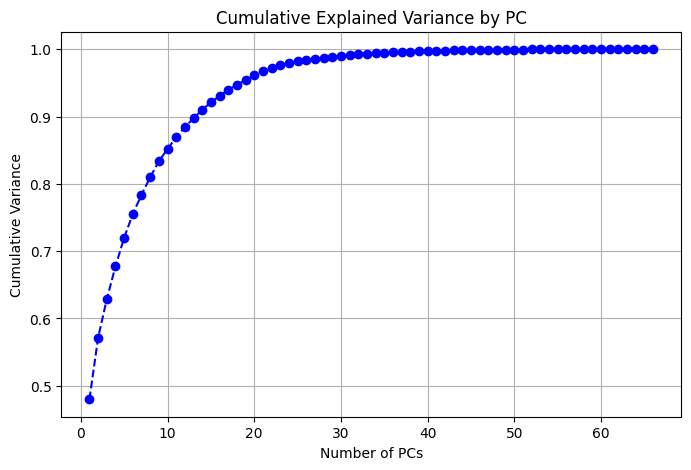

In [12]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# --- Visualize Explained variance ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PC')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()


In [13]:
var_exp_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})
var_exp_df.head(15)

,Component,Explained Variance,Cumulative Variance
0,PC1,0.479985,0.479985
1,PC2,0.091548,0.571533
2,PC3,0.057183,0.628716
3,PC4,0.048658,0.677374
4,PC5,0.042645,0.720019
5,PC6,0.035187,0.755205
6,PC7,0.028354,0.783560
7,PC8,0.026076,0.809635
8,PC9,0.023872,0.833507
9,PC10,0.018117,0.851624


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
pca = PCA(n_components=13)  # <- aquí defines cuántos componentes quieres
X_pca = pca.fit_transform(X_scaled)  # ahora X_pca tendrá shape (n_muestras, 13)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(13)])


In [15]:
import pandas as pd
X_pca_df = pd.DataFrame(X_pca[:, :13], columns=[f'PC{i+1}' for i in range(13)])

In [16]:

def create_pca_df(X_pca, n_components=13):
    """
    Convierte un array de PCA en un DataFrame listo para clustering.

    Parámetros:
    -----------
    X_pca : numpy.ndarray
        Array resultante de la transformación PCA (p.ej., pca.transform(X))
    n_components : int, opcional
        Número de componentes principales a incluir en el DataFrame (default=13)

    Retorna:
    --------
    pd.DataFrame
        DataFrame con columnas PC1, PC2, ..., PCn
    """
    df = pd.DataFrame(X_pca[:, :n_components],
                      columns=[f'PC{i+1}' for i in range(n_components)])
    return df
